## PBMC integration

uniPort effectively integrates the scATAC and scRNA data by common, RNA-specific and ATAC-specific (in the form of gene activity matrix) highly variable genes without using pairing information.

In [1]:
import uniport as up
import numpy as np
import pandas as pd
import scanpy as sc
print(up.__version__)

1.1.0


Read the preprocessed data.

In [2]:
adata_atac = sc.read_h5ad('PBMC/atac.h5ad')
adata_rna = sc.read_h5ad('PBMC/rna.h5ad')
adata_cm = sc.read_h5ad('PBMC/atac_and_rna.h5ad')

In [3]:
adatas = [adata_atac, adata_rna]

### Integration with specific genes and optimal transport loss
Integrate the scATAC-seq and scRNA-seq data using both common and dataset-specific genes by `Run` function in uniport. The latent representations of data are stored in `adata.obs['latent']`.

In [4]:
adata = up.Run(adatas=adatas, adata_cm=adata_cm, lambda_kl=1.0, lambda_s=1.0)

2022-05-12 16:40:27,885 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=2000, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
    (var_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (dec): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=16, out_features=2000, bias=True)
            (norm): DSBa

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'




Epochs: 100%|█| 345/345 [11:30<00:00,  2.00s/it, recloss=1143.40,klloss=12.35,ot


Perform UMAP visualization.

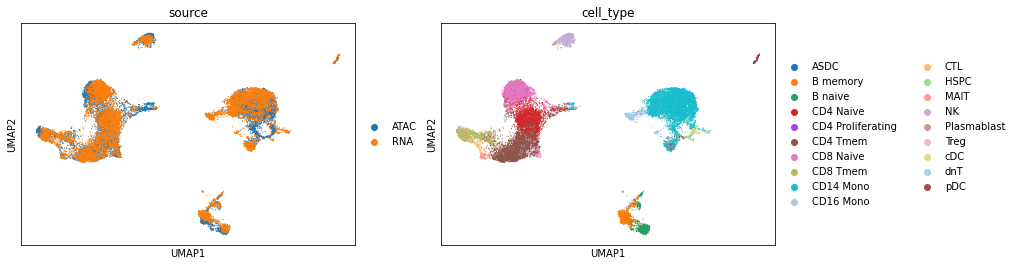

In [5]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Project data after training
To project data into the latent space without training, we can set `out='project'`.

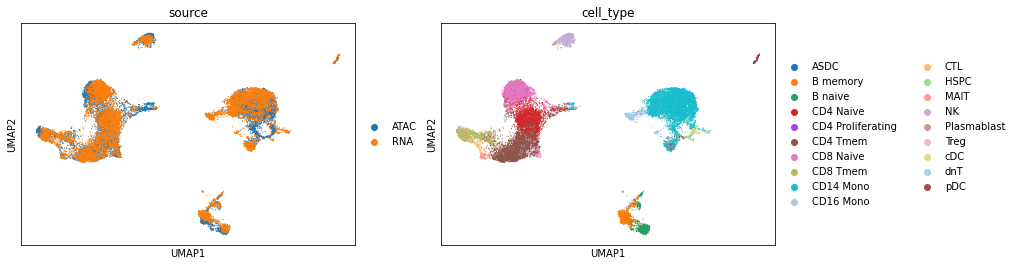

In [6]:
adata = up.Run(adata_cm=adata_cm, out='project')
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Integration without specific genes
Integrate the scATAC-seq and scRNA-seq data using only common genes.

2022-05-12 16:53:54,027 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=2000, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
    (var_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (dec): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=16, out_features=2000, bias=True)
            (norm): DSBa

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'source_colors', 'cell_type_colors'
    obsm: 'latent', 'X_umap', 'project'
    obsp: 'distances', 'connectivities'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'source_colors', 'cell_type_colors'
    obsm: 'latent', 'X_umap', 'project'
    obsp: 'distances', 'connectivities'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_ty

Epochs: 100%|█| 345/345 [09:46<00:00,  1.70s/it, recloss=443.19,klloss=4.62,otlo


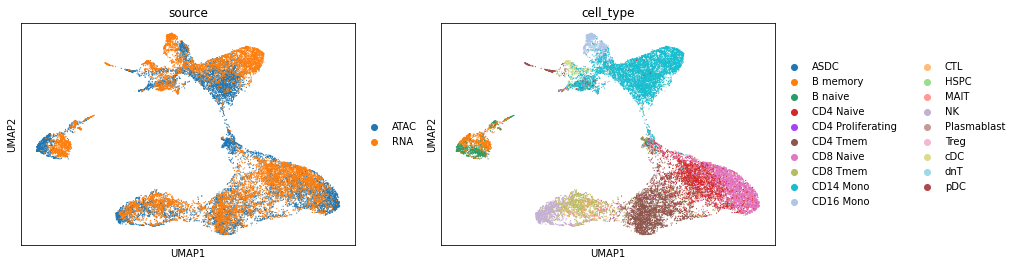

In [7]:
adata = up.Run(adata_cm=adata_cm, lambda_kl=1.0)
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Integration without optimal transport loss
Integrate the scATAC-seq and scRNA-seq data without optimal transport loss.

2022-05-12 17:09:02,300 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=2000, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
    (var_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (dec): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=16, out_features=2000, bias=True)
            (norm): DSBa

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'




Epochs: 100%|█| 345/345 [11:42<00:00,  2.04s/it, recloss=794.56,klloss=9.27,otlo


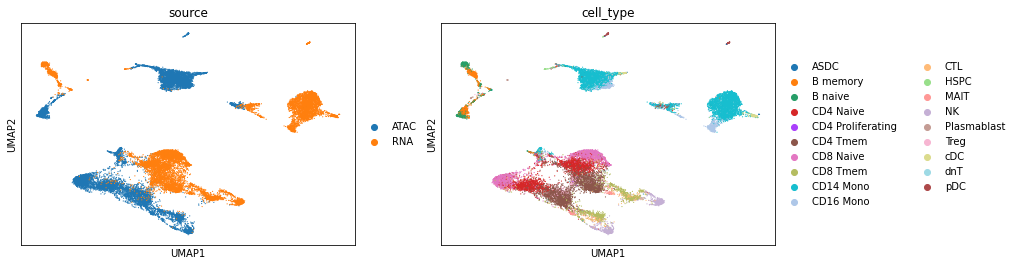

In [8]:
adata = up.Run(adatas=adatas, adata_cm=adata_cm, lambda_kl=1.0, lambda_ot=0)
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])